Clean up raw popluation data

- expand it to each year

In [1]:
# free up memory
import gc
gc.collect()

41

In [3]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt

In [4]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [28]:
data_dir = '../../Extended_Data/Population/'

In [29]:
files = os.listdir(data_dir)
# only check files ending with .nc
files = [f for f in files if f.endswith('.nc')]
files

['population_density.2000.2020.CA.nc']

In [30]:
file = files[0]
file

'population_density.2000.2020.CA.nc'

In [31]:
population_dat = xr.open_dataset(f'{data_dir}{file}').squeeze()

In [9]:
population_dat

<xarray.Dataset>
Dimensions:             (time: 5, lat: 585, lon: 1386)
Coordinates:
  * time                (time) datetime64[ns] 2000-01-01 ... 2020-01-01
  * lat                 (lat) float64 25.07 25.11 25.15 ... 49.32 49.36 49.4
  * lon                 (lon) float64 -124.8 -124.7 -124.7 ... -67.1 -67.06
Data variables:
    population_density  (time, lat, lon) float64 ...

In [32]:
population_dat = population_dat.to_dataframe().reset_index()

In [11]:
population_dat.head()

,time,lat,lon,population_density
0,2000-01-01,25.066667,-124.766667,NaN
1,2000-01-01,25.066667,-124.725000,NaN
2,2000-01-01,25.066667,-124.683333,NaN
3,2000-01-01,25.066667,-124.641667,NaN
4,2000-01-01,25.066667,-124.600000,NaN


In [12]:
# check unique values of time
population_dat['time'].unique()

<DatetimeArray>
['2000-01-01 00:00:00', '2005-01-01 00:00:00', '2010-01-01 00:00:00',
 '2015-01-01 00:00:00', '2020-01-01 00:00:00']
Length: 5, dtype: datetime64[ns]

In [13]:
population_dat_lon_lat = population_dat[['lon', 'lat']].drop_duplicates()
population_dat_lon_lat.shape

(810810, 2)

In [16]:
population_dat_2000 = population_dat[population_dat['time'] == '2000-01-01T00:00:00']
population_dat_2000.shape

(810810, 4)

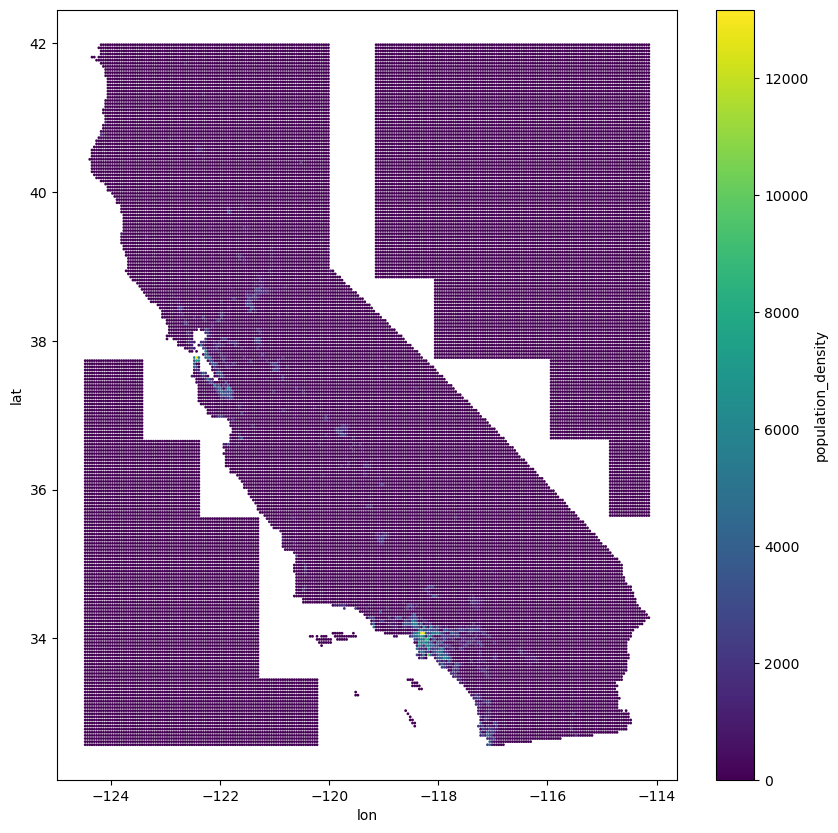

In [17]:
population_dat_2000.plot(kind='scatter', x='lon', y='lat', c='population_density', cmap='viridis', s=1, figsize=(10, 10))
plt.show()

## Check lon, lat w weather data

In [18]:
reference_weather_data = pd.read_parquet('../../Clean_Data/Weather_Data/Extended_Weather_Data/wind_speed.parquet')
reference_weather_data = reference_weather_data[reference_weather_data['day']=='1998-01-01']
reference_weather_data = reference_weather_data[['lon', 'lat']].drop_duplicates()
reference_weather_data.shape

(61404, 2)

In [19]:
test_merge = population_dat_lon_lat.merge(reference_weather_data, on=['lon', 'lat'], how='inner')
# if test_merge.shape is same as reference_weather_data, then the merge is successful
if test_merge.shape == reference_weather_data.shape:
    print("Merge successful")
else:
    # print test_merge shape and reference_weather_data shape
    print(f"Merge failed: {test_merge.shape} != {reference_weather_data.shape}")

Merge successful


## Missing Rate

In [33]:
population_dat.head()

,time,lat,lon,population_density
0,2000-01-01,25.066667,-124.766667,NaN
1,2000-01-01,25.066667,-124.725000,NaN
2,2000-01-01,25.066667,-124.683333,NaN
3,2000-01-01,25.066667,-124.641667,NaN
4,2000-01-01,25.066667,-124.600000,NaN


In [21]:
# check missing rate
key_variable = 'population_density'
# group by water year
missing_rate_by_year = population_dat.groupby('time')[key_variable].apply(lambda x: x.isnull().mean())
missing_rate_by_year

time
2000-01-01    0.943912
2005-01-01    0.943912
2010-01-01    0.943912
2015-01-01    0.943912
2020-01-01    0.943912
Name: population_density, dtype: float64

## Save Data

In [34]:
path_to_save = '../../Clean_Data/Extended_Data/Population'
# Ensure the output directory exists
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

output_file = f'{path_to_save}/{file.split(".")[0]}.parquet'
population_dat.to_parquet(output_file)

print(f"Saved {file} as {output_file}")

Saved population_density.2000.2020.CA.nc as ../../Clean_Data/Extended_Data/Population//population_density.parquet


## Merge w Veg Data

In [35]:
# clean up memory
gc.collect()
# delete all dataframes
for var in list(globals().keys()):
    if isinstance(globals()[var], pd.DataFrame):
        del globals()[var]

In [36]:
import os
from datetime import datetime
import pandas as pd

# the data is generated from 02 Veg Data Extract.ipynb
veg_data = pd.read_parquet('../../Clean_Data/lon_lat_pair_weather_match_veg_v2.parquet')
veg_data_filter = veg_data[~veg_data['veg'].str.contains('Water|Urban|Agriculture')]

In [37]:
veg_data_filter.shape

(14383, 7)

In [38]:
file = 'population_density.parquet'

In [39]:
path_to_read = '../../Clean_Data/Extended_Data/Population'
path_to_save = '../../Clean_Data/Extended_Data_w_Veg_Filter/Population'
# Ensure the output directory exists
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

print("Task: Data cleaning on new Population data with vegetation filter")
print(f"Processing started on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


dat = pd.read_parquet(f'{path_to_read}/{file}')
print(f"Processing file: {file}, shape: {dat.shape}")
dat_filtered = pd.merge(dat, veg_data_filter[['lon', 'lat']], on=['lon', 'lat'], how='inner')
print(f"Filtered DataFrame shape: {dat_filtered.shape}")
del dat  # Free up memory
dat_filtered.to_parquet(f'{path_to_save}/{file}')

Task: Data cleaning on new Population data with vegetation filter
Processing started on: 2025-06-14 13:03:17
Processing file: population_density.parquet, shape: (4054050, 4)
Filtered DataFrame shape: (71915, 4)


In [40]:
# check missing rate
key_variable = 'population_density'
# group by water year
missing_rate_by_year = dat_filtered.groupby('time')[key_variable].apply(lambda x: x.isnull().mean())
missing_rate_by_year

time
2000-01-01    0.029132
2005-01-01    0.029132
2010-01-01    0.029132
2015-01-01    0.029132
2020-01-01    0.029132
Name: population_density, dtype: float64

## Expand to each year

In [22]:
path_to_read = '../../Clean_Data/Extended_Data_w_Veg_Filter/Population'
file = 'population_density.parquet'
dat = pd.read_parquet(f'{path_to_read}/{file}')

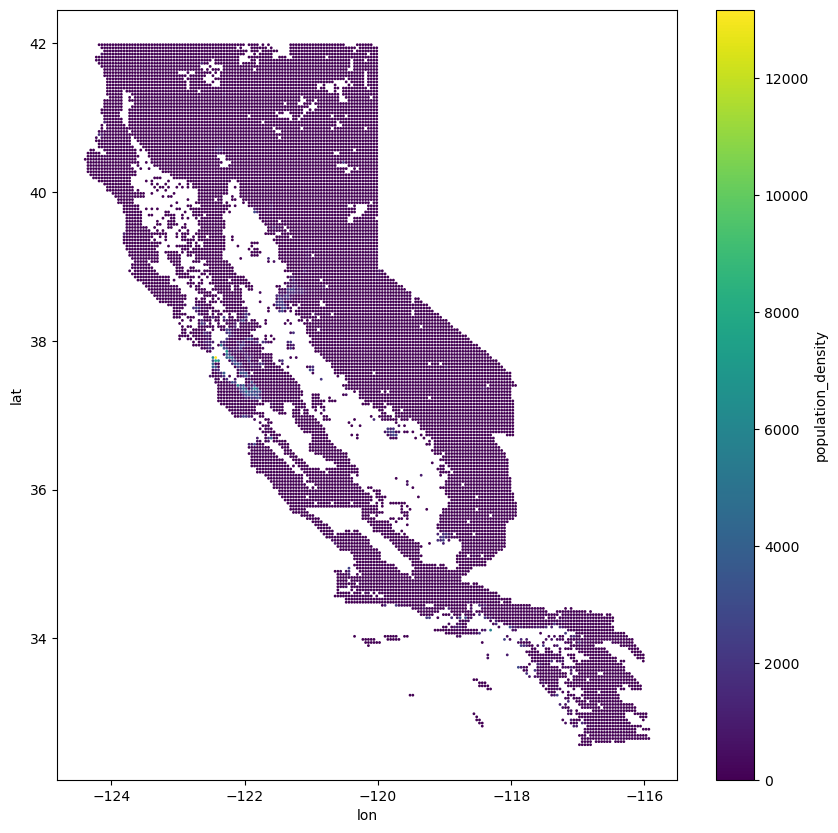

In [7]:
population_dat_2000 = dat[dat['time'] == '2000-01-01T00:00:00']
population_dat_2000.plot(kind='scatter', x='lon', y='lat', c='population_density', cmap='viridis', s=1, figsize=(10, 10))
plt.show()

In [9]:
dat['time'].unique()

<DatetimeArray>
['2000-01-01 00:00:00', '2005-01-01 00:00:00', '2010-01-01 00:00:00',
 '2015-01-01 00:00:00', '2020-01-01 00:00:00']
Length: 5, dtype: datetime64[ns]

In [10]:
dat.dtypes

time                  datetime64[ns]
lat                          float64
lon                          float64
population_density           float64
dtype: object

In [ ]:
dat['year_in_population_dat'] = dat['time'].dt.year

In [24]:
dat['year_in_population_dat'].unique()

array([2000, 2005, 2010, 2015, 2020])

In [25]:
dat.shape

(71915, 5)

In [26]:
dat.head()

,time,lat,lon,population_density,year_in_population_dat
0,2000-01-01,32.566667,-116.975000,1.381242,2000
1,2000-01-01,32.566667,-116.933333,1.327153,2000
2,2000-01-01,32.566667,-116.891667,0.000000,2000
3,2000-01-01,32.566667,-116.850000,0.141186,2000
4,2000-01-01,32.566667,-116.808333,7.825610,2000


In [27]:
# Create a new DataFrame with all the years from 2000 to 2020
years = list(range(1994, 2021))
lon_lat = dat[['lon', 'lat']].drop_duplicates()
new_df = pd.DataFrame([(year, lon, lat) for year in years for lon, lat in lon_lat.values], columns=['year', 'lon', 'lat'])

# Define a function to map each year to the nearest specified year
def map_year(year):
    if year <= 2004:
        return 2000
    elif year <= 2009:
        return 2005
    elif year <= 2014:
        return 2010
    elif year <= 2019:
        return 2015
    else:
        return 2020

# Apply the function to create a new column with the mapped years
new_df['year_in_population_dat'] = new_df['year'].apply(map_year)

In [28]:
# group by mapped_year, and year, value_counts
grouped_counts = new_df.groupby(['year','year_in_population_dat']).size().reset_index(name='count')
grouped_counts

,year,year_in_population_dat,count
0,1994,2000,14383
1,1995,2000,14383
2,1996,2000,14383
3,1997,2000,14383
4,1998,2000,14383
5,1999,2000,14383
6,2000,2000,14383
7,2001,2000,14383
8,2002,2000,14383
9,2003,2000,14383


In [29]:
new_df.columns, dat.columns

(Index(['year', 'lon', 'lat', 'year_in_population_dat'], dtype='object'),
 Index(['time', 'lat', 'lon', 'population_density', 'year_in_population_dat'], dtype='object'))

In [39]:
population_dat = pd.merge(new_df, dat, on=['year_in_population_dat', 'lon', 'lat'], how = "inner")
# drop time
population_dat = population_dat.drop(columns=['time','year_in_population_dat'])

In [40]:
population_dat.shape, new_df.shape

((388341, 4), (388341, 4))

In [41]:
population_dat.head()

,year,lon,lat,population_density
0,1994,-116.975000,32.566667,1.381242
1,1994,-116.933333,32.566667,1.327153
2,1994,-116.891667,32.566667,0.000000
3,1994,-116.850000,32.566667,0.141186
4,1994,-116.808333,32.566667,7.825610


In [43]:
# check unique values of year
population_dat['year'].unique()

array([1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020], dtype=int64)

In [42]:
# missing rate for all columns
population_dat.isnull().mean()

year                  0.000000
lon                   0.000000
lat                   0.000000
population_density    0.029132
dtype: float64

In [44]:
path_to_save = '../../Clean_Data/Extended_Data_w_Veg_Filter/Population'
# Ensure the output directory exists
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
file_name = 'population_density_yearly_1994_2020.parquet'
population_dat.to_parquet(f'{path_to_save}/{file_name}')